# Explore different parametrizations of the beta distribution



In [ ]:
#@title
install.packages("reshape2")
install.packages("ggplot2")
install.packages("viridis")
set.seed(42)
library(viridis)
library(reshape2)
library(ggplot2)



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘gridExtra’


Loading required package: viridisLite



In [ ]:
#@title
### set theme
theme_set(theme_bw())

In [ ]:
#@title
mu.list<-c(0,0.2,0.5,0.8,1)
phi.list<-c(0,0.2,0.5,0.7,1,5,10,50)
n.simul<-1000
df.params<-expand.grid(mu=mu.list,phi=phi.list)
r.beta<-mapply(function(x,y)(rbeta(n.simul,x, y)),df.params[,1],df.params[,2])
colnames(r.beta)<-apply( cbind.data.frame(mu="mu",df.params[,1],phi="phi",df.params[,2]) , 1 , paste , collapse = "-" )
df.rbeta<-melt(t(r.beta) ); colnames(df.rbeta)[1]<-"params"; 
df.rbeta$phi<-as.numeric(do.call("rbind",lapply(as.character(df.rbeta$params), function(x) unlist(strsplit((x), "-")) ))[,4])


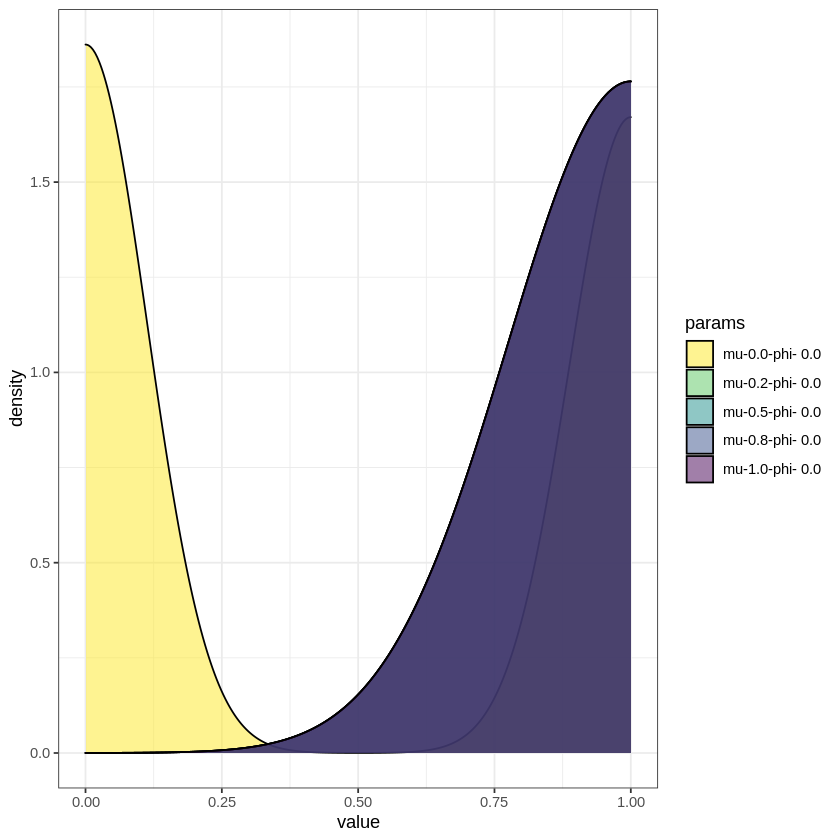

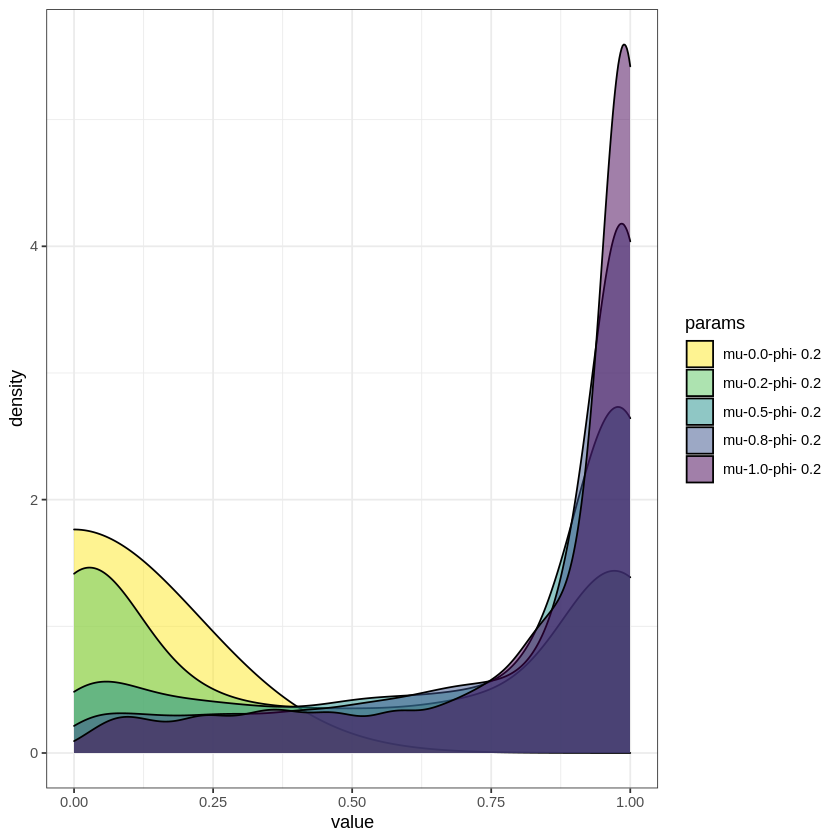

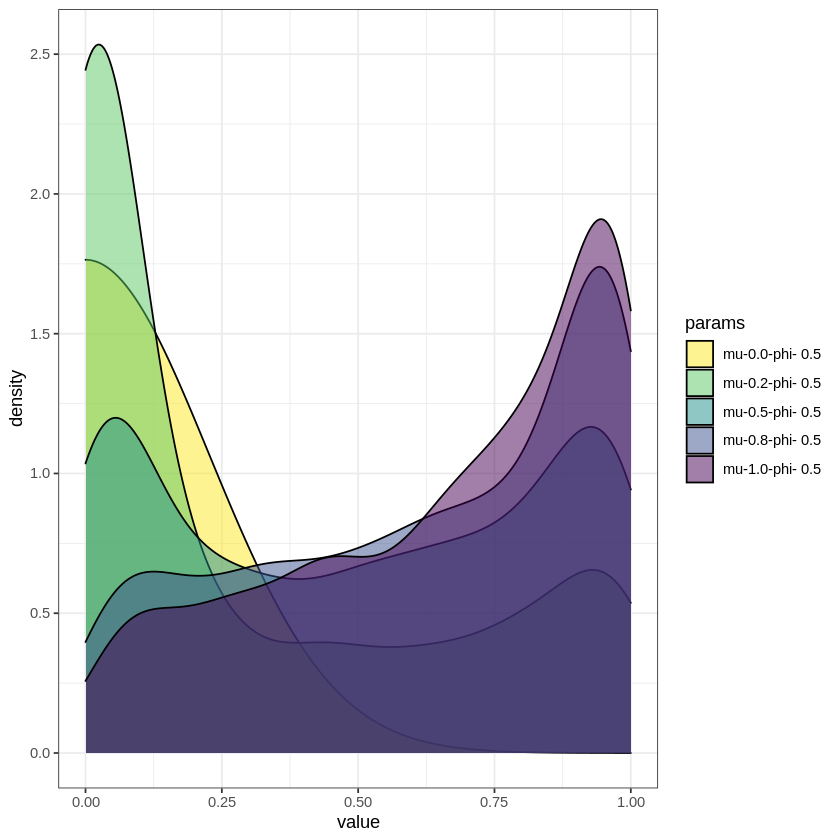

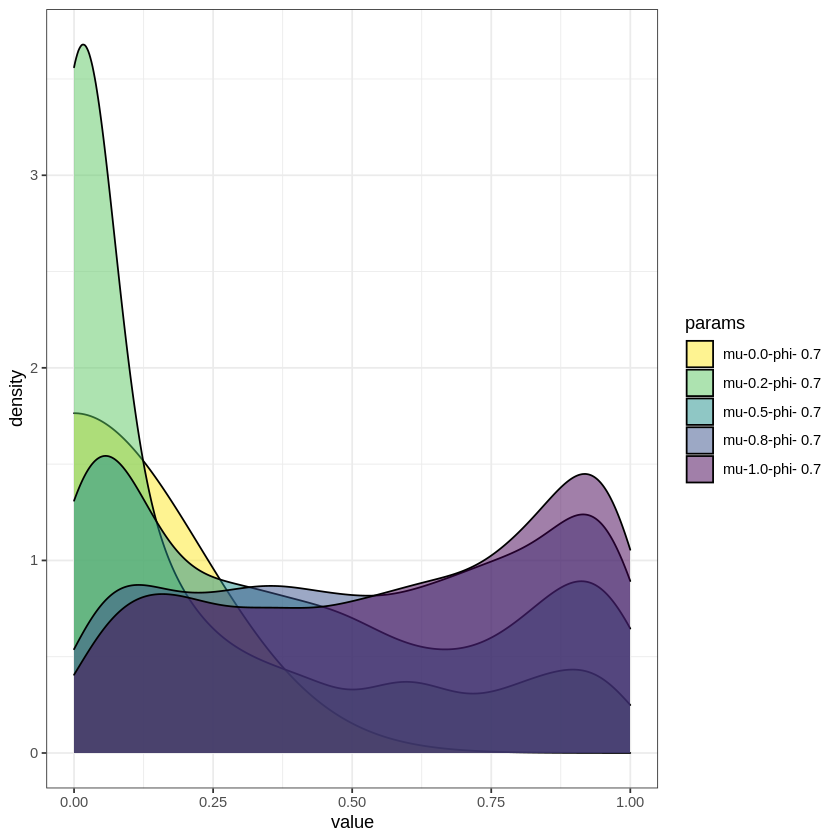

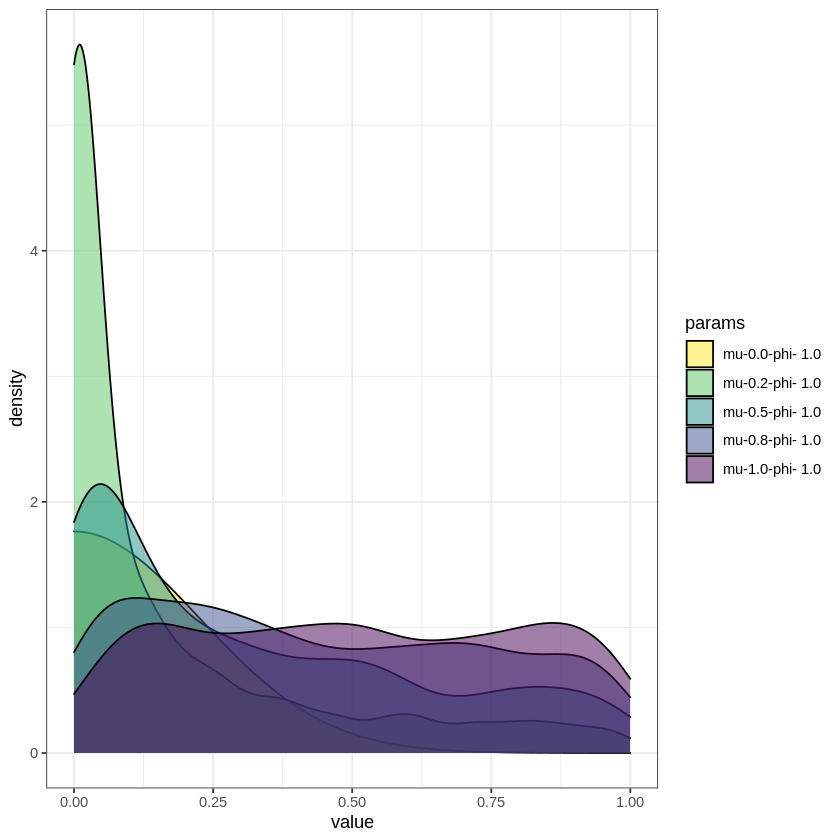

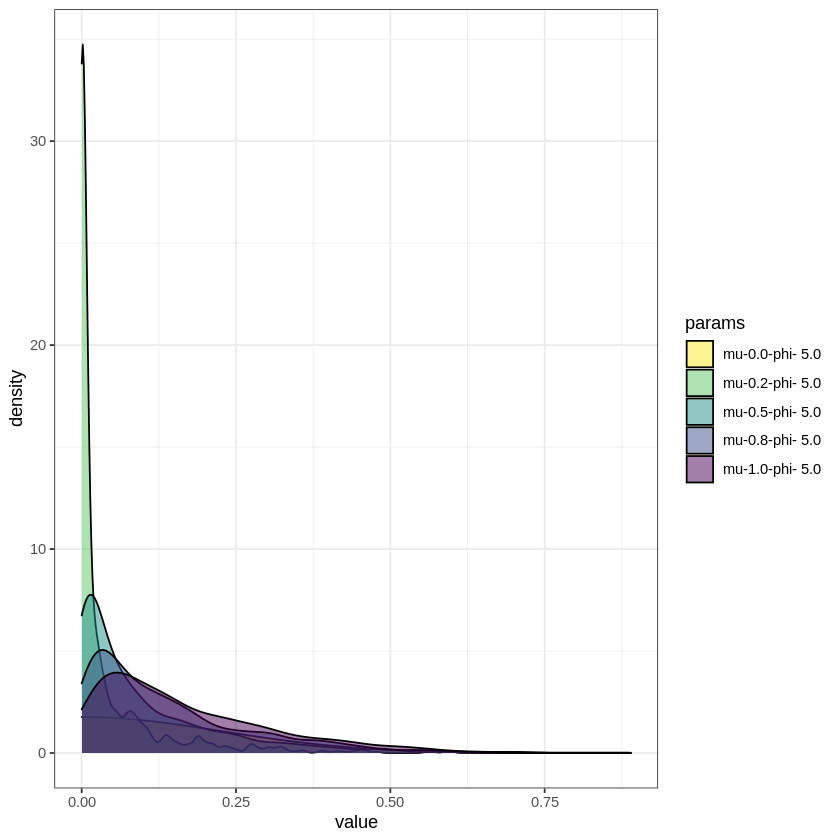

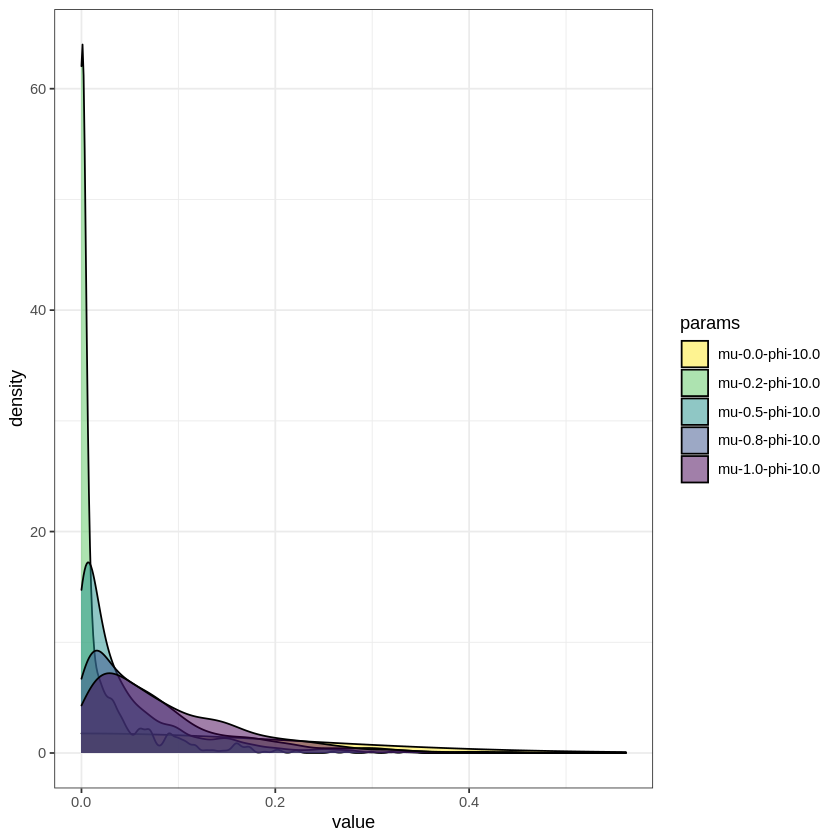

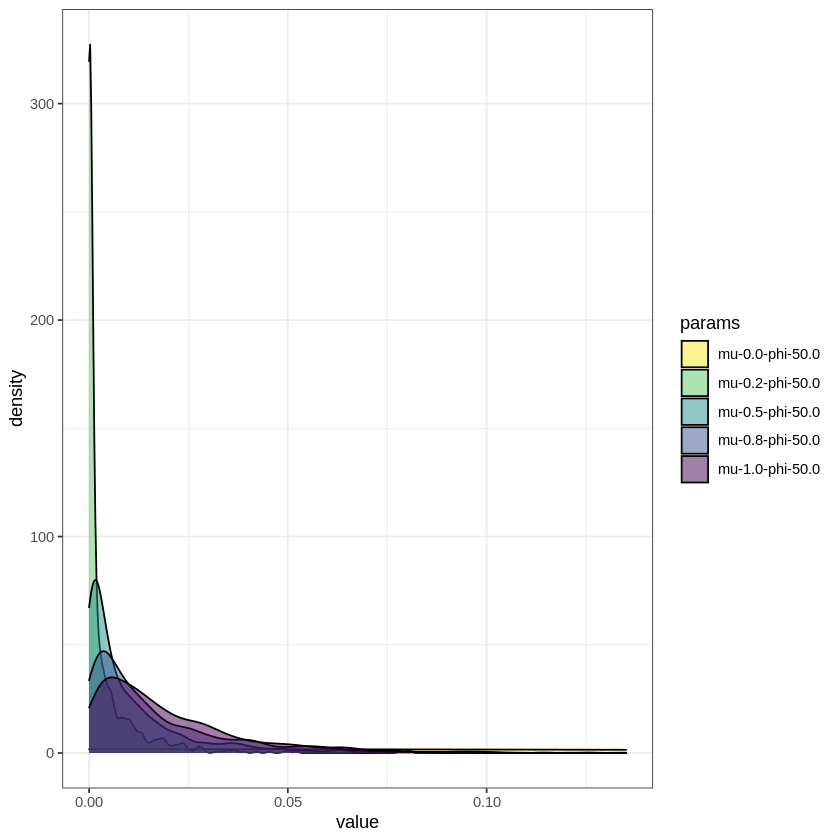

In [ ]:
#@title
gg.list<-list()
i<-0
for(phi.i in phi.list){i<-i+1
(gg.dens<-ggplot(subset(df.rbeta,phi==phi.i), aes(x = value, fill = params)) + geom_density(alpha = 0.5))+ ggtitle(paste0("Dispersion parameter ",phi.i)  )
gg.list[[i]]<-gg.dens +  scale_fill_viridis_d(direction = -1)
}

for(i in 1:length(phi.list)){
print(gg.list[[i]])
}

## Conclusions
Select dispersion parameter phi 0.2 and 0.5 as it seems to be more similar to the distributions seen in real data.  

# Simulations of genetic diseases using beta distribution.

## Disease model
$$logit(\mu_{j})= \alpha_{0}+b_{i}+G_{j}\beta$$

* $G_{j}$ is the normalized genotype matrix for individual $j$
* $\beta$ is the genetic effect sizes (log odds), where for each snp $i$, $\beta_{i}$ has distribution $N(0,p_{i}(1-p_{i})^{-0.3})$.
* $\alpha_{0}$ is the prevalence of the disease. 
* $b$ is a random effect that accounts for the environmental variation, where  $b_j \sim N(0,\tau)$. And $\tau$ is the liability threshold. 

If we asume Y has Beta distribution, $Y_j \sim Beta(\mu_j, \phi)$.

$$E[Y_j|\alpha_{0},G_j]=\mu_j$$
$$\mu_j=g^{-1}(\alpha_{0}+G^T\beta)=expit(\alpha_{0}+G^T\beta)$$
$$Var(Y_j|\alpha_{0},G_j)=\mu_j(1-\mu_j)/(1+ \phi)$$

## Parameters used for simulations.
MAF thresholds: 0.0001,0.001,0.01,0.1,0.3

Case fraction: 0.3, 0.1, 0.03,0.01

First consider simulated genotypes and and phentoypes. Where we have two phenotypes: 
1. The propensity score $Y_j$ with $Beta(\mu_j, \phi)$ distributions.
2. The inferred case/control, $Z_j$, status where $Z_j \sim Bernoulli( Y_j)$. 



### Simulate propensity score

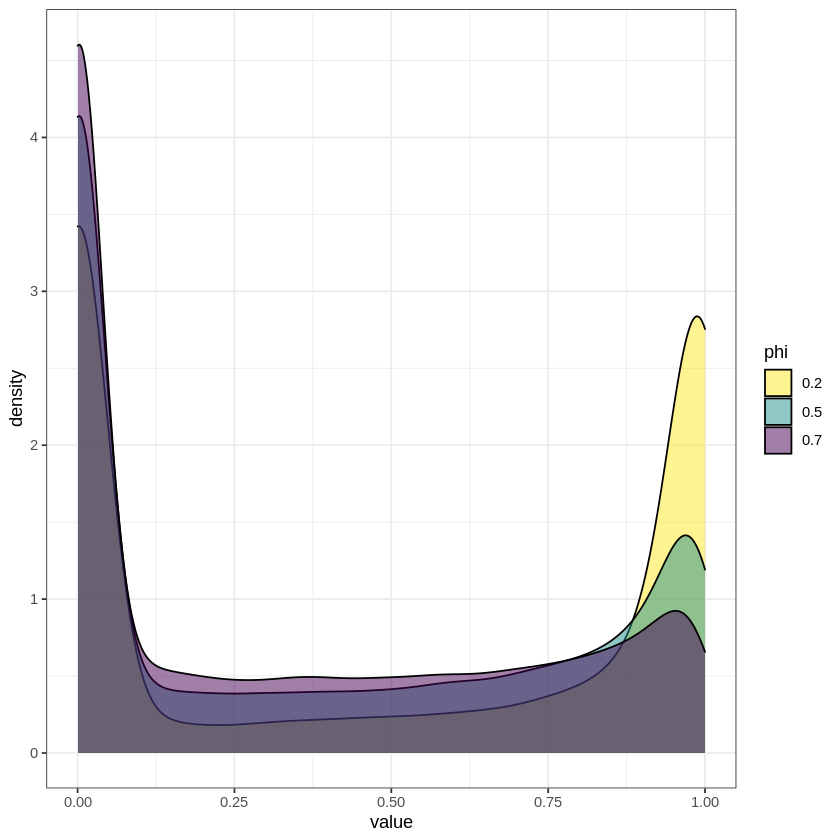

In [ ]:
#@title
 expit<-function(x) exp(x)/(1+exp(x))
  n<-50000 # number of persons
  prev<-0.3 # prevalence
  M<-100 # number of variants
  phi.list<-c(0.2,0.5,0.7)
  maf.list<-c(0.0001,0.001,0.01,0.1,0.3)
  num.snps.maf<-round(M/length(maf.list))
  alphaG_array<-as.matrix(unlist(lapply(maf.list, function(x) rnorm(num.snps.maf,0,sqrt( (x*(1-x))^-0.3 )) )) )
  G<-do.call("rbind",lapply(1:n,function(y) unlist(lapply(maf.list, function(x) (rbinom(num.snps.maf,size=2,prob=x)-2*x)/sqrt(2*x*(1-x))   )) ))
  
  #X = prev+ G %*% alphaG_array + rnorm(n,0,1)
  X = prev+ G %*% alphaG_array
  mu<-expit(X)
  Y.mt<-do.call("cbind", lapply(phi.list ,function(y) unlist(lapply(mu,function(x) rbeta(1,x, y))) ) )
  colnames(Y.mt)<-phi.list
  ###Y<-unlist(lapply(mu,function(x) rbeta(1,x, 0.5)))
  Y.mt.2<-melt(Y.mt); colnames(Y.mt.2)[2]<-"phi"
  as.character(Y.mt.2$phi)->Y.mt.2$phi
  print(gg.dens<-ggplot(Y.mt.2[,-1], aes(x = value, fill = phi)) + geom_density(alpha = 0.5)  +  scale_fill_viridis_d(direction = -1))


### Simulate binary phenotype

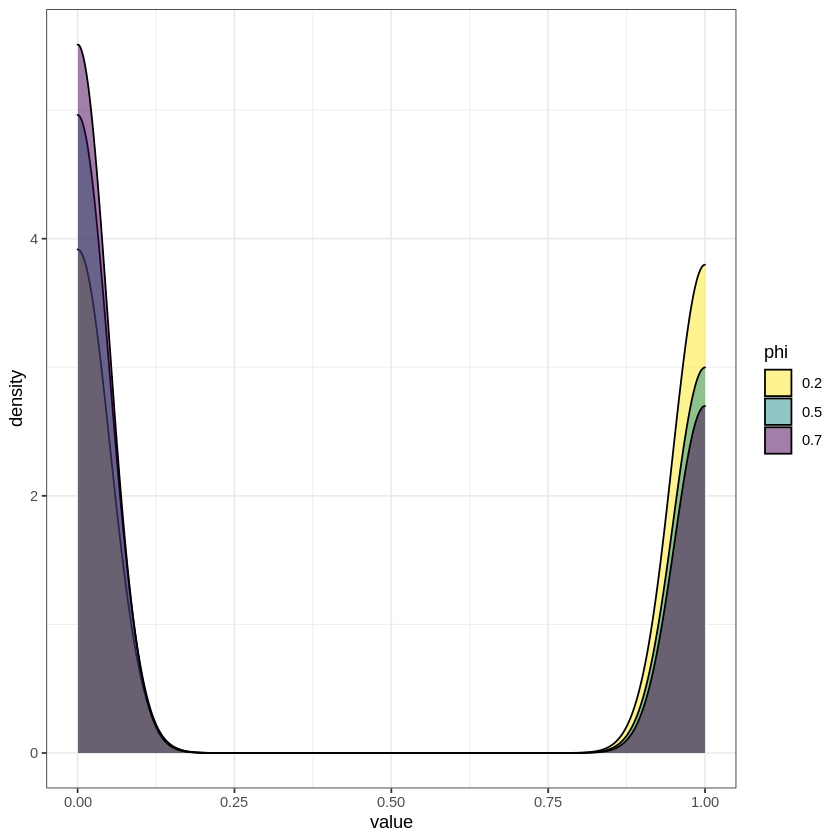

In [ ]:
#@title
  Y_bin<-do.call("cbind",lapply(1:length(phi.list) ,function(j) unlist(lapply(Y.mt[,j],function(p) rbinom(1,1,p) )) ) )
  colnames(Y_bin)<-phi.list
  Y_bin.2<-melt(Y_bin); colnames(Y_bin.2)[2]<-"phi"
  as.character(Y_bin.2$phi)->Y_bin.2$phi
  print(gg.dens<-ggplot(Y_bin.2[,-1], aes(x = value, fill = phi)) + geom_density(alpha = 0.5)  +  scale_fill_viridis_d(direction = -1) ) 


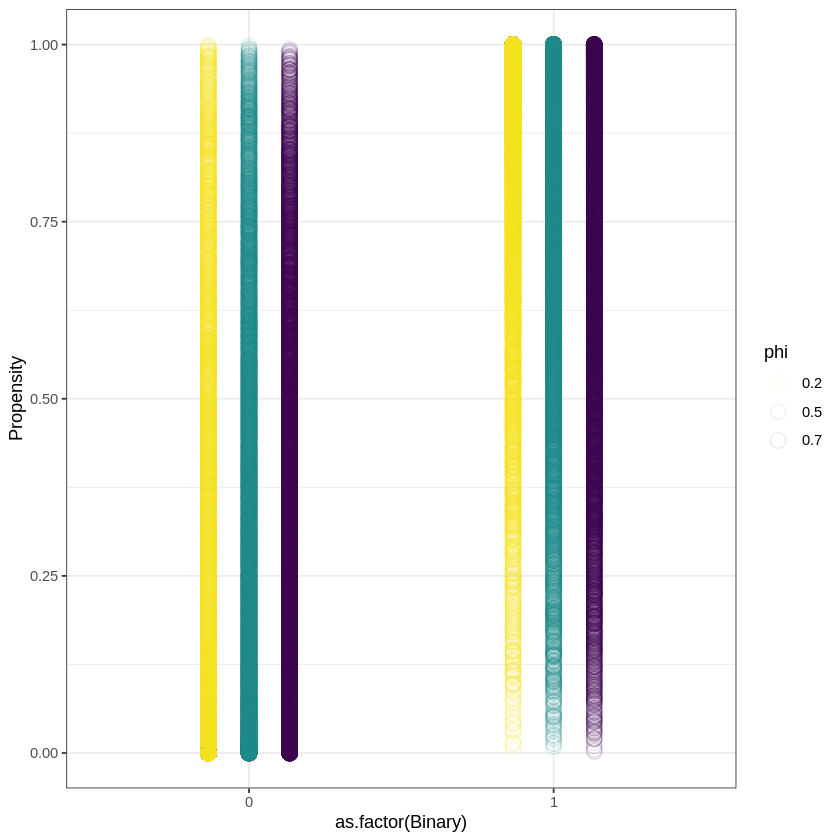

In [ ]:
#@title
Y_bin_mt<-merge(Y_bin.2,Y.mt.2,by=c("Var1","phi")); colnames(Y_bin_mt)[3:4]<-c("Binary","Propensity")
gg_points<-ggplot(Y_bin_mt, aes(x =as.factor(Binary), y = Propensity)) + geom_point(aes(color = phi), shape = 1, size = 4, position = position_dodge(width = 0.4),alpha=0.1) + scale_colour_viridis_d(direction = -1)
print(gg_points)

## Association test


In [ ]:
#@title
## binary association test
funct.iter.bin<-function(y) {assoc.df<-do.call("rbind",lapply(1:M,
  function(x){
  coef.glm<-summary(glm(Y_bin[,y] ~ G[,x],family = binomial))$coef 
  if(dim(coef.glm)[1]>1){
  effs.glm<-coef.glm[2,];  }
  else{
    effs.glm<-rep(NA,4)
  }
  return(effs.glm) 
  })) 
return(assoc.df)
}

## lm association test
funct.iter.lm<-function(y) {assoc.df<-do.call("rbind",lapply(1:M,
  function(x){
  coef.glm<-summary(lm(Y_norm[,y] ~ G[,x]))$coef 
  if(dim(coef.glm)[1]>1){
  effs.glm<-coef.glm[2,];  }
  else{
    effs.glm<-rep(NA,4)
  }
  return(effs.glm) 
  })) 
return(assoc.df)
}

Run logistic regression 

In [ ]:
#@title
maf.bins<-seq(0,M,by=num.snps.maf)
d.assoc.bin<-lapply(1:3, funct.iter.bin)

In [ ]:
#@title
maf.bins.vec<-rep(maf.list, each = num.snps.maf)

In [ ]:
#@title
d.power.bin<-lapply(1:3,function(y){
d.assoc.bin2<-cbind.data.frame(cut=maf.bins.vec,d.assoc.bin[[y]])
colnames(d.assoc.bin2)[4]<-"Chi2"; colnames(d.assoc.bin2)[5]<-"P"
(avg.chi2.bin<-cbind.data.frame(maf=maf.list,aggregate(Chi2 ~ cut, d.assoc.bin2,function(x) mean(x^2), na.action = na.omit )) )
(avg.pval.bin<-cbind.data.frame(maf=maf.list,aggregate(P ~ cut, d.assoc.bin2,function(x) mean(x<10^-8), na.action = na.omit )) )
return(cbind.data.frame(avg.chi2.bin,pval=avg.pval.bin[,3]))})

In [ ]:
#@title


Run linear regression

In [ ]:
#@title
  install.packages("RNOmni")
  library(RNOmni)
  Y_norm<-do.call("cbind",lapply(1:length(phi.list) ,function(j) RankNorm(Y.mt[,j])  ) )
colnames(Y_norm)<-phi.list

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘RcppArmadillo’




In [ ]:
#@title
## Run linear regression
d.assoc.lm<-lapply(1:3, funct.iter.lm)

In [ ]:
#@title
d.power.lm<-lapply(1:3,function(y){
d.assoc.lm2<-cbind.data.frame(cut=maf.bins.vec,d.assoc.lm[[y]])
colnames(d.assoc.lm2)[4]<-"Chi2"; colnames(d.assoc.lm2)[5]<-"P";
(avg.chi2.lm<-cbind.data.frame(maf=maf.list,aggregate(Chi2 ~ cut, d.assoc.lm2,function(x) mean(x^2), na.action = na.omit )) )
(avg.pval.lm<-cbind.data.frame(maf=maf.list,aggregate(P ~ cut, d.assoc.lm2,function(x) mean(x<10^-8), na.action = na.omit )) )
return(cbind.data.frame(avg.chi2.lm,pval=avg.pval.lm[,3]))})

## Power analysis

*Comparison number of SNPs that had p-value $< 10^{-8}$ stratified by MAF bins between propensity score compared to a binary trait.*



Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”


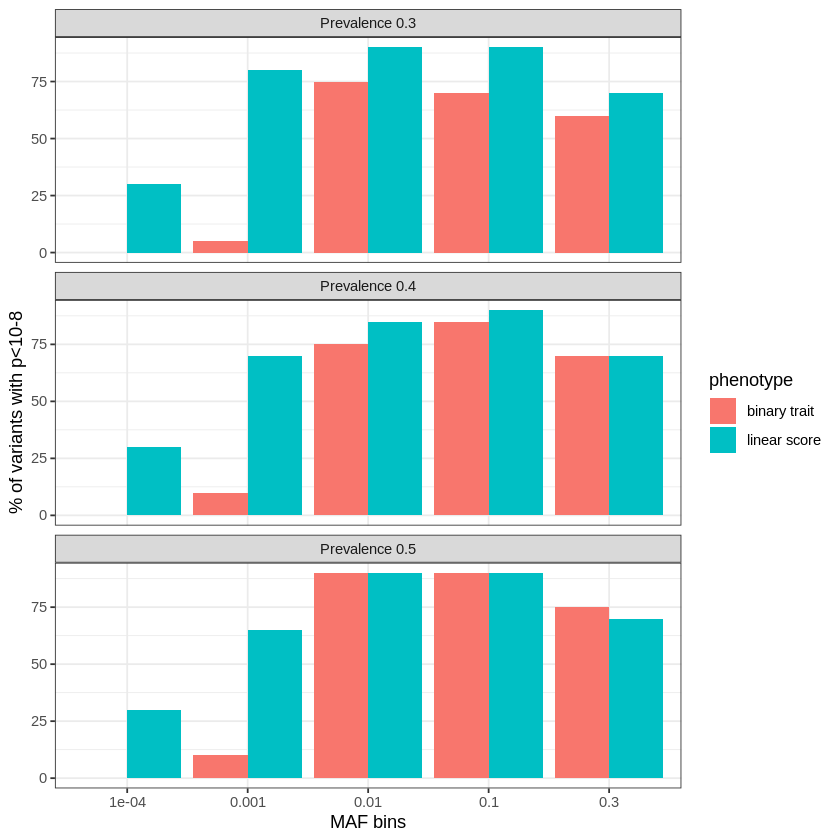

In [ ]:
#@title
prev_list<-round(colMeans(Y_bin),1)

df.plot<-do.call("rbind",lapply(1:3, function(y){
  rbind(cbind.data.frame(phenotype="linear score",phi=phi.list[y],prevalence=prev_list[y],d.power.lm[[y]]),cbind.data.frame(phenotype="binary trait",phi=phi.list[y],prevalence=prev_list[y],d.power.bin[[y]]))
}))
df.plot$pval<-df.plot$pval*100 
as.factor(df.plot$maf)->df.plot$maf

supp.labs <- paste0("Prevalence ",prev_list)
names(supp.labs) <- prev_list

library(ggplot2)
ggpl<-ggplot(data=df.plot, aes(x=maf, y=pval, fill=phenotype)) +
geom_bar(stat="identity", position=position_dodge())+facet_wrap(~prevalence,  ncol=1,labeller = labeller(prevalence = supp.labs) )+ylab("% of variants with p<10-8")+xlab("MAF bins")
print(ggpl)



*Comparison of average Chi2 statistic value stratified by MAF bins between propensity score compared to a binary trait.*

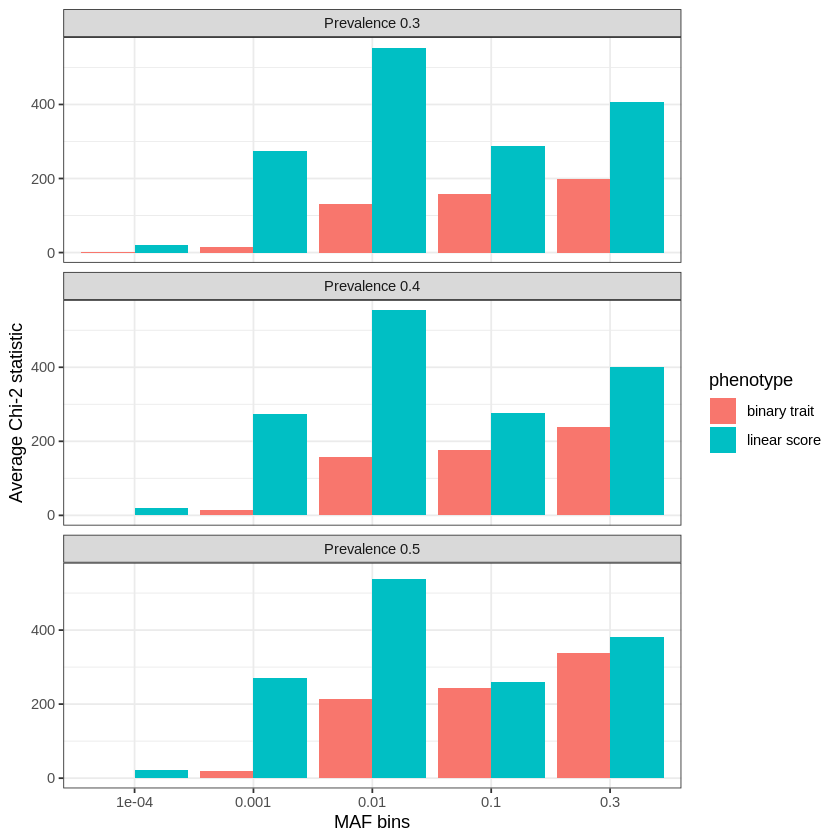

In [ ]:
#@title
ggplchi<-ggplot(data=df.plot, aes(x=maf, y=Chi2, fill=phenotype)) +
geom_bar(stat="identity", position=position_dodge())+facet_wrap(~prevalence,  ncol=1,labeller = labeller(prevalence = supp.labs))+ylab("Average Chi-2 statistic")+xlab("MAF bins")
print(ggplchi)

Print relative difference (%) between using propensity score compared to a binary trait.

In [ ]:
#@title
lapply(1:3,function(y) cbind.data.frame(phi=phi.list[y],maf=d.power.lm[[y]][,1],((d.power.lm[[y]][,3:4]/d.power.bin[[y]][,3:4])-1 )*100 ) )

phi,maf,Chi2,pval
<dbl>,<dbl>,<dbl>,<dbl>
0.2,1e-04,1660.579934,Inf
0.2,1e-03,1305.862974,550.000000
0.2,1e-02,151.754579,0.000000
0.2,1e-01,6.734119,0.000000
0.2,3e-01,12.344071,-6.666667
phi,maf,Chi2,pval
<dbl>,<dbl>,<dbl>,<dbl>
0.5,1e-04,1568.60555,Inf
0.5,1e-03,1786.87180,600.000000
